In [1]:
import pandas as pd
import anndata as ad
import sys

In [248]:
import os
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
from scipy.spatial import Delaunay
import scipy.stats as st

def calculate_triangulation_distances(df_input, id, x_pos, y_pos, cell_type, region):
    # Perform Delaunay triangulation
    points = df_input[[x_pos, y_pos]].values
    tri = Delaunay(points)
    indices = tri.simplices
    
    # Get interactions going both directions
    edges = set()
    for simplex in indices:
        for i in range(3):
            for j in range(i + 1, 3):
                edges.add(tuple(sorted([simplex[i], simplex[j]])))
    edges = np.array(list(edges))
    
    # Create dataframe from edges
    rdelaun_result = pd.DataFrame(edges, columns=['ind1', 'ind2'])
    rdelaun_result[['x1', 'y1']] = df_input.iloc[rdelaun_result['ind1']][[x_pos, y_pos]].values
    rdelaun_result[['x2', 'y2']] = df_input.iloc[rdelaun_result['ind2']][[x_pos, y_pos]].values
    
    # Annotate results with cell type and region information
    df_input['XYcellID'] = df_input[x_pos].astype(str) + "_" + df_input[y_pos].astype(str)
    rdelaun_result['cell1ID'] = rdelaun_result['x1'].astype(str) + "_" + rdelaun_result['y1'].astype(str)
    rdelaun_result['cell2ID'] = rdelaun_result['x2'].astype(str) + "_" + rdelaun_result['y2'].astype(str)
    
    annotated_result = pd.merge(rdelaun_result, df_input, left_on='cell1ID', right_on='XYcellID')
    annotated_result = annotated_result.rename(columns={cell_type: 'celltype1', id: 'celltype1_index'})
    annotated_result = annotated_result.drop(columns=[x_pos, y_pos, region, 'XYcellID'])
    
    annotated_result = pd.merge(annotated_result, df_input, left_on='cell2ID', right_on='XYcellID', suffixes=('.x', '.y'))
    annotated_result = annotated_result.rename(columns={cell_type: 'celltype2', id: 'celltype2_index'})
    annotated_result = annotated_result.drop(columns=[x_pos, y_pos, 'XYcellID'])
    
    # Calculate distance
    annotated_result['distance'] = np.sqrt((annotated_result['x2'] - annotated_result['x1']) ** 2 +
                                           (annotated_result['y2'] - annotated_result['y1']) ** 2)
    
    # Reorder columns
    annotated_result = annotated_result[[region, 'celltype1_index', 'celltype1', 'x1', 'y1', 'celltype2_index', 'celltype2', 'x2', 'y2', 'distance']]
    annotated_result.columns = [region, 'celltype1_index', 'celltype1', 'celltype1_X', 'celltype1_Y',
                                'celltype2_index', 'celltype2', 'celltype2_X', 'celltype2_Y', 'distance']
    
    return annotated_result


# Define the process_region function at the top level
def process_region(df, unique_region, id, x_pos, y_pos, cell_type, region):
    subset = df[df[region] == unique_region].copy()
    subset['uniqueID'] = subset[id].astype(str) + "-" + subset[x_pos].astype(str) + "-" + subset[y_pos].astype(str)
    subset['XYcellID'] = subset[x_pos].astype(str) + "_" + subset[y_pos].astype(str)
    result = calculate_triangulation_distances(df_input=subset, id=id, x_pos=x_pos, y_pos=y_pos,
                                               cell_type=cell_type, region=region)
    return result

def get_triangulation_distances(df_input, id, x_pos, y_pos, cell_type, region,
                                num_cores=None, correct_dtype = True):
    
    if correct_dtype == True:
        # change columns to pandas string
        df[cell_type] = df[cell_type].astype(str)
        df[region] = df[region].astype(str)
    
    # Check if x_pos and y_pos are integers, and if not, convert them
    if not issubclass(df_input[x_pos].dtype.type, np.integer):
        print("This function expects integer values for xy coordinates.")
        print("Class will be changed to integer. Please check the generated output!")
        df_input[x_pos] = df_input[x_pos].astype(int)
        df_input[y_pos] = df_input[y_pos].astype(int)
    
    # Get unique regions
    unique_regions = df_input[region].unique()
    
    # Select only necessary columns
    df_input = df_input[[id, x_pos, y_pos, cell_type, region]]
    
    # Set up parallelization
    if num_cores is None:
        num_cores = os.cpu_count() // 2  # default to using half of available cores
    
    # Parallel processing using joblib
    results = Parallel(n_jobs=num_cores)(delayed(process_region)(df_input, reg, id, x_pos, y_pos, cell_type, region)
                                         for reg in unique_regions)
    
    triangulation_distances = pd.concat(results)
    
    
    return triangulation_distances

import pandas as pd
import numpy as np

def shuffle_annotations(df_input, cell_type, region, permutation):
    # Set the seed for reproducibility
    np.random.seed(permutation + 1234)

    # Create a copy to avoid modifying the original dataframe
    df_shuffled = df_input.copy()

    # Shuffle annotations within each region
    for region_name in df_shuffled[region].unique():
        region_mask = df_shuffled[region] == region_name
        shuffled_values = df_shuffled.loc[region_mask, cell_type].sample(frac=1).values
        df_shuffled.loc[region_mask, 'random_annotations'] = shuffled_values

    return df_shuffled


def iterate_triangulation_distances(df_input, id, x_pos, y_pos, cell_type, region, num_cores=None, num_iterations=1000):
    unique_regions = df_input[region].unique()
    # Use only the necessary columns
    df_input = df_input[[id, x_pos, y_pos, cell_type, region]]

    if num_cores is None:
        num_cores = os.cpu_count() // 2  # Default to using half of available cores
    
    # Define a helper function to process each region and iteration
    def process_iteration(region_name, iteration):
        # Filter by region
        subset = df_input[df_input[region] == region_name]
        # Create unique IDs
        subset['uniqueID'] = subset[id].astype(str) + "-" + subset[x_pos].astype(str) + "-" + subset[y_pos].astype(str)
        subset['XYcellID'] = subset[x_pos].astype(str) + "_" + subset[y_pos].astype(str)
        
        # Shuffle annotations
        shuffled = shuffle_annotations(subset, cell_type, region, iteration)
  
        # Get triangulation distances
        results = get_triangulation_distances(df_input = shuffled, id = id, x_pos = x_pos, y_pos= y_pos, cell_type="random_annotations", region = region, num_cores = num_cores,  correct_dtype = False)
        
        # Summarize results
        per_cell_summary = results.groupby(['celltype1_index', 'celltype1', 'celltype2']).distance.mean().reset_index(name='per_cell_mean_dist')
        
        per_celltype_summary = per_cell_summary.groupby(['celltype1', 'celltype2']).per_cell_mean_dist.mean().reset_index(name='mean_dist')
        per_celltype_summary[region] = region_name
        per_celltype_summary['iteration'] = iteration
        
        return per_celltype_summary
    
    # Parallel processing for each region and iteration
    results = Parallel(n_jobs=num_cores)(
        delayed(process_iteration)(region_name, iteration)
        for region_name in unique_regions
        for iteration in range(1, num_iterations + 1)
    )
    
    # Combine all results
    iterative_triangulation_distances = pd.concat(results, ignore_index=True)
    #iterative_triangulation_distances = iterative_triangulation_distances.dropna()
    return iterative_triangulation_distances


def add_missing_columns(triangulation_distances, metadata, shared_column='unique_region'):
    # Find the difference in columns
    missing_columns = set(metadata.columns) - set(triangulation_distances.columns)
    # Add missing columns to triangulation_distances with NaN values
    for column in missing_columns:
        triangulation_distances[column] = pd.NA
        # Create a mapping from unique_region to tissue in metadata
        region_to_tissue = pd.Series(metadata[column].values, index=metadata['unique_region']).to_dict()

        # Apply this mapping to the triangulation_distances dataframe to create/update the tissue column
        triangulation_distances[column] = triangulation_distances['unique_region'].map(region_to_tissue)

        # Handle regions with no corresponding tissue in the metadata by filling in a default value
        triangulation_distances[column].fillna('Unknown', inplace=True)
    return triangulation_distances

# Calculate p-values and log fold differences
# def calculate_pvalue(row):
#    try:
#        return st.ttest_ind(row['expected'], row['observed'], alternative='two-sided', equal_var = False).pvalue
#    except ValueError:  # This handles cases with insufficient data
#        return np.nan

# Calculate p-values and log fold differences
def calculate_pvalue(row):
    try:
        return st.mannwhitneyu(row['expected'], row['observed'], alternative='two-sided').pvalue
    except ValueError:  # This handles cases with insufficient data
        return np.nan
    
def identify_potential_interactions(triangulation_distances, iterative_triangulation_distances, metadata, min_observed = 10, distance_threshold = 128, comparison = 'tissue'):
    
    # Reformat observed dataset
    triangulation_distances_long = add_missing_columns(triangulation_distances, metadata, shared_column='unique_region')

    observed_distances = (
        triangulation_distances_long
        .query('distance <= @distance_threshold')
        .groupby(['celltype1_index', 'celltype1', 'celltype2', comparison, 'unique_region'])
        .agg(mean_per_cell=('distance', 'mean'))
        .reset_index()
        .groupby(['celltype1', 'celltype2', comparison])
        .agg(observed=('mean_per_cell', list),
            observed_mean=('mean_per_cell', 'mean'))
        .reset_index()
    )
    
    # Reformat expected dataset
    iterated_triangulation_distances_long = add_missing_columns(iterative_triangulation_distances, metadata, shared_column='unique_region')

    expected_distances = (
        iterated_triangulation_distances_long
        .query('mean_dist <= @distance_threshold')
        .groupby(['celltype1', 'celltype2', comparison])
        .agg(expected=('mean_dist', list),
            expected_mean=('mean_dist', 'mean'))
        .reset_index()
    )
    
    # Drop comparisons with low numbers of observations
    observed_distances['keep'] = observed_distances['observed'].apply(lambda x: len(x) > min_observed)
    observed_distances = observed_distances[observed_distances['keep']]

    expected_distances['keep'] = expected_distances['expected'].apply(lambda x: len(x) > min_observed)
    expected_distances = expected_distances[expected_distances['keep']]
    
    # concatenate observed and expected distances
    distance_pvals = expected_distances.merge(observed_distances, on=['celltype1', 'celltype2', comparison], how='left')
    
    distance_pvals = expected_distances.merge(observed_distances, on=['celltype1', 'celltype2', comparison], how='left')
    distance_pvals['pvalue'] = distance_pvals.apply(calculate_pvalue, axis=1)
    distance_pvals['logfold_group'] = np.log2(distance_pvals['observed_mean'] / distance_pvals['expected_mean'])
    distance_pvals['interaction'] = distance_pvals['celltype1'] + " --> " + distance_pvals['celltype2']
    
    #drop na from distance_pvals
    # distance_pvals = distance_pvals.dropna()
    
    return distance_pvals

In [102]:
# read adata object
input_dir = '/Volumes/Tim_Extern/'
adata = ad.read_h5ad(input_dir+"adata_nn_demo_hubmap_intestine_20231014_annotated.h5ad")

In [103]:
df = pd.DataFrame(adata.obs)
df.head()

,x,y,region_num,donor,tissue,region,area,unique_region,leiden_1,leiden_1.5,leiden_1_subcluster,leiden_2,celltype,leiden_1_subcluster_22,celltype_fine,celltype_fine_new
0,2.019231,35.865385,4,B004,CL,reg004,52.0,B004_CL_reg4,11,14,11,4,Smooth muscle,11,Smooth muscle,Smooth muscle
1,4.009615,110.221154,4,B004,CL,reg004,104.0,B004_CL_reg4,26,35,26,48,ICC,26,ICC,ICC
2,1.315789,347.157895,4,B004,CL,reg004,19.0,B004_CL_reg4,11,14,11,4,Smooth muscle,11,Smooth muscle,Smooth muscle
3,3.132353,705.058824,4,B004,CL,reg004,68.0,B004_CL_reg4,9,13,9,21,Stroma,9,Stroma,Stroma
4,3.740741,1795.537037,4,B004,CL,reg004,54.0,B004_CL_reg4,15,12,15,9,TA,15,Smooth muscle,Smooth muscle


In [104]:
# subset df for metadata
metadata = df[["donor", "tissue", "region", "unique_region"]]
metadata.head()

,donor,tissue,region,unique_region
0,B004,CL,reg004,B004_CL_reg4
1,B004,CL,reg004,B004_CL_reg4
2,B004,CL,reg004,B004_CL_reg4
3,B004,CL,reg004,B004_CL_reg4
4,B004,CL,reg004,B004_CL_reg4


In [105]:
df["index"] = df.index

In [140]:
triangulation_distances = get_triangulation_distances(df_input = df, 
                                                      id = "index", 
                                                      x_pos = "x", 
                                                      y_pos = "y", 
                                                      cell_type = "celltype", 
                                                      region = "unique_region", 
                                                      num_cores=10)

In [109]:
triangulation_distances

,unique_region,celltype1_index,celltype1,celltype1_X,celltype1_Y,celltype2_index,celltype2,celltype2_X,celltype2_Y,distance
0,B004_CL_reg4,6527,Nerve,3248,494,6548,TA,3257,393,101.400197
1,B004_CL_reg4,6535,TA,3253,355,6548,TA,3257,393,38.209946
2,B004_CL_reg4,6500,TA,3231,393,6548,TA,3257,393,26.000000
3,B004_CL_reg4,6527,Nerve,3248,494,6558,TA,3262,550,57.723479
4,B004_CL_reg4,6454,Smooth muscle,3202,592,6558,TA,3262,550,73.239334
...,...,...,...,...,...,...,...,...,...,...
100386,B004_CL_reg1,213013,CD66+ Enterocyte,2159,8234,213093,CD66+ Enterocyte,2172,8246,17.691806
100387,B004_CL_reg1,231666,Enterocyte,8309,8502,231709,Enterocyte,8324,8512,18.027756
100388,B004_CL_reg1,231094,Enterocyte,8126,7206,231188,CD8+ T cell,8160,7206,34.000000
100389,B004_CL_reg1,201758,NK,276,5097,201834,Smooth muscle,299,5091,23.769729


In [141]:
iterative_triangulation_distances = iterate_triangulation_distances(df_input=df, 
                                                                    num_iterations=10, 
                                                                    id='index', 
                                                                    x_pos='x', 
                                                                    y_pos='y', 
                                                                    cell_type='celltype', 
                                                                    region='unique_region',
                                                                    num_cores = 10)

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_50626/1338242059.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_50626/1338242059.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_50626/1338242059.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [142]:
iterative_triangulation_distances

,celltype1,celltype2,mean_dist,unique_region,iteration
0,CD4+ T cell,CD4+ T cell,68.194439,B004_CL_reg4,1
1,CD4+ T cell,CD66+ Enterocyte,29.668849,B004_CL_reg4,1
2,CD4+ T cell,CD8+ T cell,52.296113,B004_CL_reg4,1
3,CD4+ T cell,DC,89.506223,B004_CL_reg4,1
4,CD4+ T cell,Endothelial,55.321623,B004_CL_reg4,1
...,...,...,...,...,...
35111,Unknown,Plasma,49.983129,B004_CL_reg1,10
35112,Unknown,Smooth muscle,36.972098,B004_CL_reg1,10
35113,Unknown,Stroma,42.499785,B004_CL_reg1,10
35114,Unknown,TA,46.658674,B004_CL_reg1,10


In [249]:
distance_pvals = identify_potential_interactions(triangulation_distances, 
                                                 iterative_triangulation_distances, 
                                                 metadata, 
                                                 min_observed = 10, 
                                                 distance_threshold = 128, 
                                                 comparison = 'tissue')

In [250]:
distance_pvals

,celltype1,celltype2,tissue,expected,expected_mean,keep_x,observed,observed_mean,keep_y,pvalue,logfold_group,interaction
0,B cell,B cell,CL,"[17.029386365926403, 44.825765001793364, 29.72...",37.966016,True,"[27.892651361962706, 19.30776406404415, 18.912...",20.261419,True,7.415238e-10,-0.905973,B cell --> B cell
1,B cell,CD4+ T cell,CL,"[40.52514377701728, 36.51201779844385, 40.2607...",43.061976,True,"[20.687346640229066, 18.867962264113206, 23.19...",23.036270,True,1.312269e-11,-0.902507,B cell --> CD4+ T cell
2,B cell,CD66+ Enterocyte,CL,"[34.58376151139503, 30.943040513110674, 39.699...",47.708553,True,NaN,NaN,NaN,NaN,NaN,B cell --> CD66+ Enterocyte
3,B cell,CD8+ T cell,CL,"[30.114362886141453, 22.934757177184938, 39.14...",40.032291,True,"[23.259406699226016, 30.083217912982647, 21.93...",26.350519,True,1.826373e-03,-0.603333,B cell --> CD8+ T cell
4,B cell,DC,CL,"[30.03354888125898, 39.13894845250285, 86.9413...",41.192560,True,NaN,NaN,NaN,NaN,NaN,B cell --> DC
...,...,...,...,...,...,...,...,...,...,...,...,...
980,Unknown,Stroma,SB,"[29.753464612664448, 46.40869231321931, 31.278...",44.075826,True,"[55.226805085936306, 65.39113089708727, 52.801...",64.096619,True,1.587659e-06,0.540261,Unknown --> Stroma
981,Unknown,TA,CL,"[57.848000494759404, 59.405045532698374, 59.22...",48.826362,True,"[82.75868534480233, 41.79299311722801, 45.8919...",63.854456,True,4.148239e-04,0.387127,Unknown --> TA
982,Unknown,TA,SB,"[43.276495562917894, 43.51693621995731, 28.297...",44.573062,True,"[59.665735560705194, 38.27531841800928, 76.967...",54.811982,True,9.060046e-02,0.298319,Unknown --> TA
983,Unknown,Unknown,CL,"[68.51607530283617, 46.27559788909211, 66.5817...",48.670715,True,"[110.34491379306978, 19.72308292331602, 101.59...",45.260855,True,4.028565e-02,-0.104790,Unknown --> Unknown


In [251]:
# calculate absolute logfold difference
distance_pvals['logfold_group_abs'] = distance_pvals['logfold_group'].abs()

# Filter significant p-values and other specified conditions
distance_pvals_sig = distance_pvals[
    (distance_pvals['pvalue'] < 0.05) &
    (distance_pvals['celltype1'] != distance_pvals['celltype2']) &
    (~distance_pvals['observed_mean'].isna()) &
    (distance_pvals['celltype1'] != "unknown") &
    (distance_pvals['celltype2'] != "unknown") &
    (distance_pvals['celltype1'] != "Noise") &
    (distance_pvals['celltype2'] != "Noise") &
    (distance_pvals['logfold_group_abs'] > 0.8) 
]

In [252]:
distance_pvals_sig

,celltype1,celltype2,tissue,expected,expected_mean,keep_x,observed,observed_mean,keep_y,pvalue,logfold_group,interaction,logfold_group_abs
1,B cell,CD4+ T cell,CL,"[40.52514377701728, 36.51201779844385, 40.2607...",43.061976,True,"[20.687346640229066, 18.867962264113206, 23.19...",23.036270,True,1.312269e-11,-0.902507,B cell --> CD4+ T cell,0.902507
22,CD4+ T cell,B cell,CL,"[36.04505227402483, 49.627805259409094, 33.933...",45.802403,True,"[18.027756377319946, 30.57479059545078, 28.442...",23.950388,True,3.962180e-11,-0.935374,CD4+ T cell --> B cell,0.935374
27,CD4+ T cell,CD8+ T cell,CL,"[52.296112837890284, 63.7190515011733, 51.5630...",47.901377,True,"[27.202941017470888, 25.495097567963924, 18.02...",27.061342,True,2.295320e-19,-0.823834,CD4+ T cell --> CD8+ T cell,0.823834
29,CD4+ T cell,DC,CL,"[89.50622302797424, 34.688739771010994, 61.252...",49.927743,True,"[28.442925306655784, 41.48493702538308, 32.062...",26.082964,True,2.457684e-20,-0.936734,CD4+ T cell --> DC,0.936734
154,DC,CD4+ T cell,CL,"[36.74865674088024, 47.187873829191616, 46.141...",49.265392,True,"[24.041630560342615, 42.720018726587654, 39.20...",27.766928,True,1.270884e-16,-0.827207,DC --> CD4+ T cell,0.827207
260,Enterocyte,Lymphatic,CL,"[49.284495527857175, 50.03100659959407, 59.791...",50.733816,True,"[9.0, 34.539832078341085, 15.0, 19.0, 15.29705...",27.249105,True,4.195759e-19,-0.896739,Enterocyte --> Lymphatic,0.896739
385,Lymphatic,Enterocyte,CL,"[80.57122355079795, 60.45616555335567, 56.4617...",48.847971,True,"[12.083045973594572, 11.180339887498949, 16.49...",27.452745,True,1.784808e-18,-0.831348,Lymphatic --> Enterocyte,0.831348
395,Lymphatic,MUC1+ Enterocyte,CL,"[54.878127376223084, 60.67267011755107, 53.407...",45.337343,True,"[14.142135623730951, 36.147816708396334, 26.83...",25.076726,True,9.297134e-19,-0.854351,Lymphatic --> MUC1+ Enterocyte,0.854351
401,Lymphatic,Neuroendocrine,CL,"[47.85486785608438, 124.81727850273063, 43.559...",43.118498,True,"[13.601470508735444, 20.396078054371138, 30.41...",24.003854,True,2.122904e-06,-0.845041,Lymphatic --> Neuroendocrine,0.845041
480,MUC1+ Enterocyte,Lymphatic,CL,"[52.58321876687117, 60.054249492914046, 54.973...",49.335235,True,"[16.76305461424021, 22.67156809750927, 9.05538...",25.277247,True,6.083976e-19,-0.964779,MUC1+ Enterocyte --> Lymphatic,0.964779


In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming distance_pvals_interesting2 is a pandas DataFrame with the same structure as the R dataframe.
pair_to = distance_pvals_sig['interaction'].unique()

# Filtering data
data = distance_pvals[~distance_pvals['interaction'].isna()]

# Creating pairs
data['pairs'] = data['celltype1'] + "_" + data['celltype2']

# Subsetting data
distance_pvals_sub = data[data['interaction'].isin(pair_to)]


In [254]:
distance_pvals_sub_reduced = distance_pvals_sub[['tissue', 'logfold_group', 'pairs']]
distance_pvals_sub_reduced.head()

,tissue,logfold_group,pairs
1,CL,-0.902507,B cell_CD4+ T cell
22,CL,-0.935374,CD4+ T cell_B cell
27,CL,-0.823834,CD4+ T cell_CD8+ T cell
28,SB,-0.665997,CD4+ T cell_CD8+ T cell
29,CL,-0.936734,CD4+ T cell_DC


In [255]:
# set pairs as index
distance_pvals_sub_reduced = distance_pvals_sub_reduced.set_index('pairs')

In [256]:
# sort logfold_group into two columns by tissue
distance_pvals_sub_reduced = distance_pvals_sub_reduced.pivot(columns='tissue', values='logfold_group')

In [257]:
distance_pvals_sub_reduced

tissue,CL,SB
pairs,,
B cell_CD4+ T cell,-0.902507,NaN
CD4+ T cell_B cell,-0.935374,NaN
CD4+ T cell_CD8+ T cell,-0.823834,-0.665997
CD4+ T cell_DC,-0.936734,-0.759879
DC_CD4+ T cell,-0.827207,-0.661978
Enterocyte_Lymphatic,-0.896739,-0.002453
Lymphatic_Enterocyte,-0.831348,0.063962
Lymphatic_MUC1+ Enterocyte,-0.854351,NaN
Lymphatic_Neuroendocrine,-0.845041,-0.018330


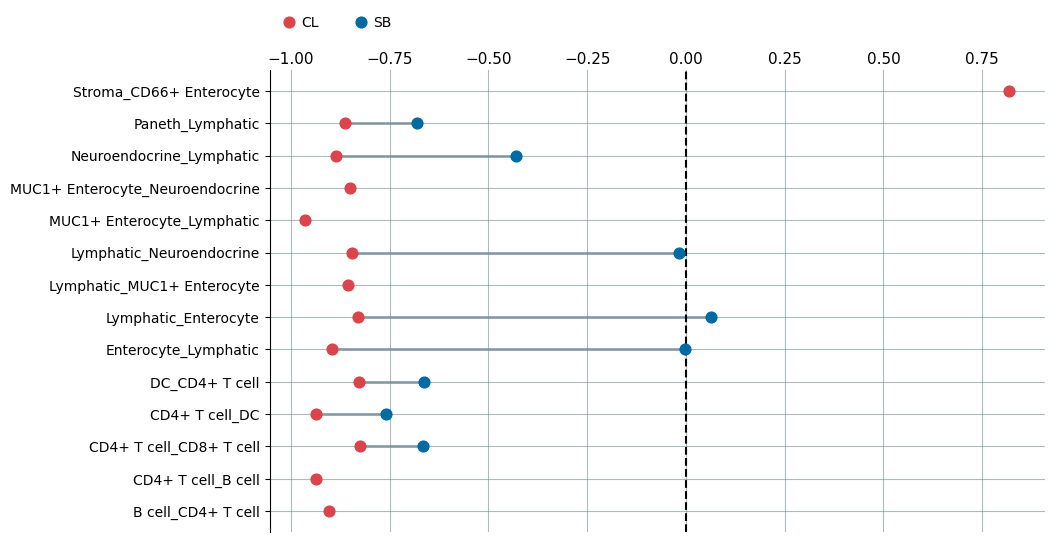

In [264]:
fig, ax = plt.subplots(figsize=(10,6), facecolor = "white")
#plot each country one at a time

# Create grid 
# Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
ax.grid(which="major", axis='both', color='#758D99', alpha=0.6, zorder=1)

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right','bottom']].set_visible(False)

# Plot data
# Plot horizontal lines first
ax.hlines(y=distance_pvals_sub_reduced.index, xmin=distance_pvals_sub_reduced["CL"], xmax=distance_pvals_sub_reduced["SB"], color='#758D99', zorder=2, linewidth=2, label='_nolegend_', alpha=.8)
# Plot bubbles next
ax.scatter(distance_pvals_sub_reduced["CL"], distance_pvals_sub_reduced.index, label='2014', s=60, color='#DB444B', zorder=3)
ax.scatter(distance_pvals_sub_reduced["SB"], distance_pvals_sub_reduced.index, label='2018', s=60, color='#006BA2', zorder=3)

# Set xlim
#ax.set_xlim(-3, 3)

# Reformat x-axis tick labels

ax.xaxis.set_tick_params(labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=11,       # Set tick label size
                         pad=-1)             # Lower tick labels a bit

ax.axvline(x=0, color='k', linestyle='--')

# Set Legend
ax.legend(['CL', 'SB'], loc=(0,1.076), ncol=2, frameon=False, handletextpad=-.1, handleheight=1)


